# 🧠 Professional nnU-Net 2025 Brain Tumor Evaluation  
<span style="color:red">by Ridwan Oladipo, MD | AI Specialist</span>  

Comprehensive evaluation of **clinical-grade brain tumor segmentation**, trained on **484 multi-modal MRI volumes**, validated on **48**, and tested on **49 holdout cases (~12,250 patches)**.  

### 📈 Performance Results  
- **Whole Tumor Dice:** ~86%  
- **Tumor Core Dice:** ~78%  
- **Enhancing Tumor Dice:** ~65%  

📊 **Rigorous validation pipeline**: BraTS-standard metrics, robustness testing (noise/intensity perturbations), clinical report generation, inference speed benchmarking, and comprehensive model documentation.  

🎯 **Clinical impact**: Transforms hours of manual tumor delineation into **seconds of AI-powered precision** for neurosurgical planning and oncology 

In [1]:
# !pip install onnxruntime-gpu
# !pip install medpy
# !pip install onnxruntime

# ⚙️ Environment Setup

In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import nibabel as nib
from scipy import ndimage
from medpy.metric import binary
import onnxruntime as ort
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings('ignore')

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Brain Tumor Evaluation Pipeline - Clinical Assessment")

Brain Tumor Evaluation Pipeline - Clinical Assessment


# 📊 Configuration and Paths

In [3]:
TEST_VOLUMES = 49
PATCH_SIZE = (96, 96, 96)
TUMOR_LABELS = {
    0: 'Background',
    1: 'Edema',
    2: 'Non-enhancing Tumor',
    3: 'Enhancing Tumor'
}

REGION_DEFINITIONS = {
    'WT': 'Whole Tumor (labels 1,2,3)',
    'TC': 'Tumor Core (labels 2,3)',
    'ET': 'Enhancing Tumor (label 3)'
}

# Paths
model_path = '/kaggle/input/brain-tumor-eval/brain-model/best_model.onnx'
test_data_dir = Path('/kaggle/input/brain-tumor-eval/brain-test-data')
results_dir = Path('/kaggle/working/evaluation_results')
results_dir.mkdir(exist_ok=True)

print(f"Test volumes: {TEST_VOLUMES}")
print(f"Model: {model_path}")
print(f"Results: {results_dir}")

Test volumes: 49
Model: /kaggle/input/brain-tumor-eval/brain-model/best_model.onnx
Results: /kaggle/working/evaluation_results


# 🔬 Load Test Data and Model

In [4]:
# Load dataset split
with open(Path(model_path).parent / 'dataset_split.json', 'r') as f:
    dataset_split = json.load(f)

test_files = [Path(f).name for f in dataset_split['test']]
print(f"Found {len(test_files)} test files")

# Load ONNX model with GPU if available
ort_session = ort.InferenceSession(
    model_path,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name
print(f"ONNX model loaded - Input: {input_name}, Output: {output_name}")
print(f"Using providers: {ort_session.get_providers()}")

# Load training metrics
with open(Path(model_path).parent / 'final_metrics.json', 'r') as f:
    training_metrics = json.load(f)

Found 49 test files
ONNX model loaded - Input: input, Output: main_out
Using providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']


# 🧮 Core Evaluation Functions

In [5]:
def extract_tumor_regions(label_volume):
    """Extract BraTS tumor regions from label volume"""
    wt = (label_volume > 0).astype(np.uint8)  # Whole tumor
    tc = ((label_volume == 2) | (label_volume == 3)).astype(np.uint8)  # Tumor core
    et = (label_volume == 3).astype(np.uint8)  # Enhancing tumor
    return {'WT': wt, 'TC': tc, 'ET': et}

def calculate_dice(pred, true):
    """Calculate Dice coefficient with BraTS-style empty case handling"""
    if np.sum(true) == 0 and np.sum(pred) == 0:
        return 1.0   # both empty
    if np.sum(true) == 0 or np.sum(pred) == 0:
        return 0.0   # one empty
    intersection = np.sum(pred * true)
    return (2.0 * intersection) / (np.sum(pred) + np.sum(true))

def calculate_hausdorff(pred, true, spacing=(1.0, 1.0, 1.0)):
    """Calculate 95th percentile Hausdorff distance"""
    if np.sum(true) == 0 and np.sum(pred) == 0:
        return 0.0
    if np.sum(true) == 0 or np.sum(pred) == 0:
        return np.inf
    return binary.hd95(pred, true, voxelspacing=spacing)

def calculate_volume_cm3(mask, spacing):
    """Calculate volume in cm³"""
    voxel_volume = np.prod(spacing) / 1000  # Convert mm³ to cm³
    return np.sum(mask) * voxel_volume

def run_inference_patches(image_volume, patch_size=(96, 96, 96), stride=(36, 36, 36)):
    """
    Patch-based inference for volumes larger than model input size.
    image_volume: [C,H,W,D] numpy array
    Returns: full-volume prediction [H,W,D]
    """
    C, H, W, D = image_volume.shape
    out_channels = 4

    # Score map and count map
    score_map = np.zeros((out_channels, H, W, D), dtype=np.float32)
    count_map = np.zeros((H, W, D), dtype=np.float32)

    # Slide over volume
    for h in range(0, H - patch_size[0] + 1, stride[0]):
        for w in range(0, W - patch_size[1] + 1, stride[1]):
            for d in range(0, D - patch_size[2] + 1, stride[2]):
                patch = image_volume[:, h:h + patch_size[0], w:w + patch_size[1], d:d + patch_size[2]]
                patch = patch[np.newaxis, ...].astype(np.float32)

                # Run inference
                input_data = {input_name: patch}
                output = ort_session.run([output_name], input_data)[0]
                output = output[0]  # remove batch

                # Add to score map
                score_map[:, h:h + patch_size[0], w:w + patch_size[1], d:d + patch_size[2]] += output
                count_map[h:h + patch_size[0], w:w + patch_size[1], d:d + patch_size[2]] += 1

    # Normalize
    score_map /= np.maximum(count_map, 1e-5)

    # Final prediction
    predictions = np.argmax(score_map, axis=0)
    return predictions

# 🛡️ Robustness Testing Functions

In [6]:
def add_gaussian_noise(image, noise_level=0.1):
    """Add Gaussian noise to image per channel"""
    noisy_image = image.copy()
    for c in range(image.shape[0]):
        mask = (image[c] != 0)
        if np.any(mask):
            noise_std = noise_level * np.std(image[c][mask])
            noise = np.random.normal(0, noise_std, image[c].shape)
            noisy_image[c][mask] += noise[mask]
    return noisy_image

def apply_intensity_shift(image, shift_factor=0.2):
    """Apply intensity shift to image per channel"""
    shifted_image = image.copy()
    for c in range(image.shape[0]):
        mask = (image[c] != 0)
        if np.any(mask):
            shift = shift_factor * np.std(image[c][mask])
            shifted_image[c][mask] += shift
    return shifted_image

def evaluate_robustness(image, label, spacing, noise_levels=[0.05, 0.1, 0.15],
                        intensity_shifts=[0.1, 0.2, 0.3]):
    """Evaluate model robustness to noise and intensity shifts"""
    robustness_results = {}

    # Baseline
    pred_baseline = run_inference_patches(image)
    regions_pred_baseline = extract_tumor_regions(pred_baseline)
    regions_true = extract_tumor_regions(label)

    baseline_dice = {}
    for region in ['WT', 'TC', 'ET']:
        baseline_dice[region] = calculate_dice(regions_pred_baseline[region], regions_true[region])

    robustness_results['baseline'] = baseline_dice

    # Noise robustness
    robustness_results['noise'] = {}
    for noise_level in noise_levels:
        noisy_image = add_gaussian_noise(image, noise_level)
        pred_noisy = run_inference_patches(noisy_image)
        regions_pred_noisy = extract_tumor_regions(pred_noisy)

        noisy_dice = {}
        for region in ['WT', 'TC', 'ET']:
            noisy_dice[region] = calculate_dice(regions_pred_noisy[region], regions_true[region])

        robustness_results['noise'][noise_level] = noisy_dice

    # Intensity shift robustness
    robustness_results['intensity'] = {}
    for shift in intensity_shifts:
        shifted_image = apply_intensity_shift(image, shift)
        pred_shifted = run_inference_patches(shifted_image)
        regions_pred_shifted = extract_tumor_regions(pred_shifted)

        shifted_dice = {}
        for region in ['WT', 'TC', 'ET']:
            shifted_dice[region] = calculate_dice(regions_pred_shifted[region], regions_true[region])

        robustness_results['intensity'][shift] = shifted_dice

    return robustness_results

# 📈 Main Evaluation Loop

In [7]:
print("Starting comprehensive evaluation on test volumes...")

evaluation_results = []
inference_times = []
robustness_summary = {'noise': {}, 'intensity': {}}

def save_overlay_pngs(image_np, label_np, pred_np, save_prefix, axis=2, step=8):
    """Save overlay PNGs for demo cases"""
    flair = image_np[..., 0]  # Use FLAIR channel
    H, W, D = flair.shape
    slices = list(range(step // 2, D, step))[:6]

    for k, z in enumerate(slices):
        base = flair[:, :, z]
        gt = label_np[:, :, z]
        pr = pred_np[:, :, z]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(base, cmap='gray')
        ax.contour(gt > 0, levels=[0.5], linewidths=1.2, alpha=0.9, colors='g')
        ax.contour(pr > 0, levels=[0.5], linewidths=1.2, alpha=0.9, colors='r')
        ax.set_axis_off()
        ax.set_title(f'{save_prefix.stem} | z={z}')

        out = results_dir / f"{save_prefix.stem}_z{z:03d}.png"
        fig.savefig(out, dpi=200, bbox_inches='tight')
        plt.close(fig)

# Process all test volumes, collect metrics
for i, test_file in enumerate(test_files):
    print(f"Processing {i + 1}/{len(test_files)}: {test_file}")

    # Load preprocessed data
    data_path = test_data_dir / test_file
    with np.load(data_path) as data:
        image = data['image'].astype(np.float32)  # [H,W,D,C]
        label = data['label'].astype(np.uint8)  # [H,W,D]
        spacing = data['target_spacing']

    # Transpose image to [C,H,W,D] for model
    image_input = np.transpose(image, (3, 0, 1, 2))

    # Inference timing
    start_time = time.time()
    predictions = run_inference_patches(image_input)
    inference_time = time.time() - start_time
    inference_times.append(inference_time)

    # Extract tumor regions
    regions_pred = extract_tumor_regions(predictions)
    regions_true = extract_tumor_regions(label)

    # Metrics
    case_results = {
        'case_id': test_file.replace('_preprocessed.npz', ''),
        'test_file': test_file,
        'inference_time': inference_time
    }

    for region in ['WT', 'TC', 'ET']:
        # Dice coefficient
        dice = calculate_dice(regions_pred[region], regions_true[region])
        case_results[f'{region}_dice'] = dice

        # Hausdorff distance
        hausdorff = calculate_hausdorff(regions_pred[region], regions_true[region], spacing)
        case_results[f'{region}_hausdorff'] = hausdorff

        # Volume calculations
        vol_true = calculate_volume_cm3(regions_true[region], spacing)
        vol_pred = calculate_volume_cm3(regions_pred[region], spacing)
        case_results[f'{region}_vol_true'] = vol_true
        case_results[f'{region}_vol_pred'] = vol_pred
        case_results[f'{region}_vol_error'] = abs(vol_pred - vol_true)

    evaluation_results.append(case_results)

    # Robustness testing on every 10th case
    if i % 10 == 0:
        print(f"  Running robustness tests...")
        rob_results = evaluate_robustness(image_input, label, spacing)

        # Aggregate robustness results
        for test_type in ['noise', 'intensity']:
            for level, metrics in rob_results[test_type].items():
                if level not in robustness_summary[test_type]:
                    robustness_summary[test_type][level] = {'WT': [], 'TC': [], 'ET': []}
                for region in ['WT', 'TC', 'ET']:
                    robustness_summary[test_type][level][region].append(metrics[region])

print(f"Evaluation complete!")

# Select diverse demo cases
results_df = pd.DataFrame(evaluation_results)

# Small tumor
small_case_id = results_df.loc[results_df['WT_vol_true'].idxmin(), 'case_id']

# Medium tumor
median_wt = results_df['WT_vol_true'].median()
medium_case_id = results_df.iloc[(results_df['WT_vol_true'] - median_wt).abs().argsort()[:1]]['case_id'].values[0]

# Large tumor
large_case_id = results_df.loc[results_df['ET_vol_true'].idxmax(), 'case_id']

demo_case_ids = [small_case_id, medium_case_id, large_case_id]
print("Selected demo cases:", demo_case_ids)

# Reload demo cases and save NPZs
manifest = []
for case_id in demo_case_ids:
    file_name = f"{case_id}_preprocessed.npz"
    data_path = test_data_dir / file_name

    with np.load(data_path) as data:
        image = data['image'].astype(np.float32)
        label = data['label'].astype(np.uint8)

    # Run inference again
    image_input = np.transpose(image, (3, 0, 1, 2))
    predictions = run_inference_patches(image_input)

    # Save inferenced NPZ
    demo_case_path = results_dir / f"inferenced_{file_name}"
    np.savez_compressed(
        demo_case_path,
        image=image,
        label=label,
        prediction=predictions
    )
    print(f"Saved demo case for Streamlit: {demo_case_path.name}")

    # Save overlay PNGs
    save_overlay_pngs(image, label, predictions, demo_case_path)

    # Build manifest entry
    row = results_df[results_df['case_id'] == case_id].iloc[0].to_dict()
    manifest.append({
        'case_id': case_id,
        'npz_file': demo_case_path.name,
        'WT_dice': float(row['WT_dice']),
        'TC_dice': float(row['TC_dice']),
        'ET_dice': float(row['ET_dice']),
        'WT_vol_true_cm3': float(row['WT_vol_true']),
        'WT_vol_pred_cm3': float(row['WT_vol_pred'])
    })

# Save manifest for Streamlit
with open(results_dir / 'demo_manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print("Demo manifest saved for Streamlit integration")

Starting comprehensive evaluation on test volumes...
Processing 1/49: BRATS_467_preprocessed.npz
  Running robustness tests...
Processing 2/49: BRATS_209_preprocessed.npz
Processing 3/49: BRATS_181_preprocessed.npz
Processing 4/49: BRATS_281_preprocessed.npz
Processing 5/49: BRATS_075_preprocessed.npz
Processing 6/49: BRATS_145_preprocessed.npz
Processing 7/49: BRATS_142_preprocessed.npz
Processing 8/49: BRATS_083_preprocessed.npz
Processing 9/49: BRATS_379_preprocessed.npz
Processing 10/49: BRATS_393_preprocessed.npz
Processing 11/49: BRATS_351_preprocessed.npz
  Running robustness tests...
Processing 12/49: BRATS_096_preprocessed.npz
Processing 13/49: BRATS_030_preprocessed.npz
Processing 14/49: BRATS_122_preprocessed.npz
Processing 15/49: BRATS_410_preprocessed.npz
Processing 16/49: BRATS_279_preprocessed.npz
Processing 17/49: BRATS_123_preprocessed.npz
Processing 18/49: BRATS_220_preprocessed.npz
Processing 19/49: BRATS_124_preprocessed.npz
Processing 20/49: BRATS_110_preprocessed.

# 📉 Performance Analysis and Visualization

PERFORMANCE SUMMARY:
WT Region:
  Dice: 0.8606 ± 0.1161
  Hausdorff: 7.35 ± 7.96 mm (∞ cases: 0)
TC Region:
  Dice: 0.7782 ± 0.2008
  Hausdorff: 9.81 ± 12.17 mm (∞ cases: 0)
ET Region:
  Dice: 0.6461 ± 0.2729
  Hausdorff: 9.93 ± 13.96 mm (∞ cases: 3)

INFERENCE SPEED:
  Average: 5.795s per volume
  Throughput: 0.2 volumes/second


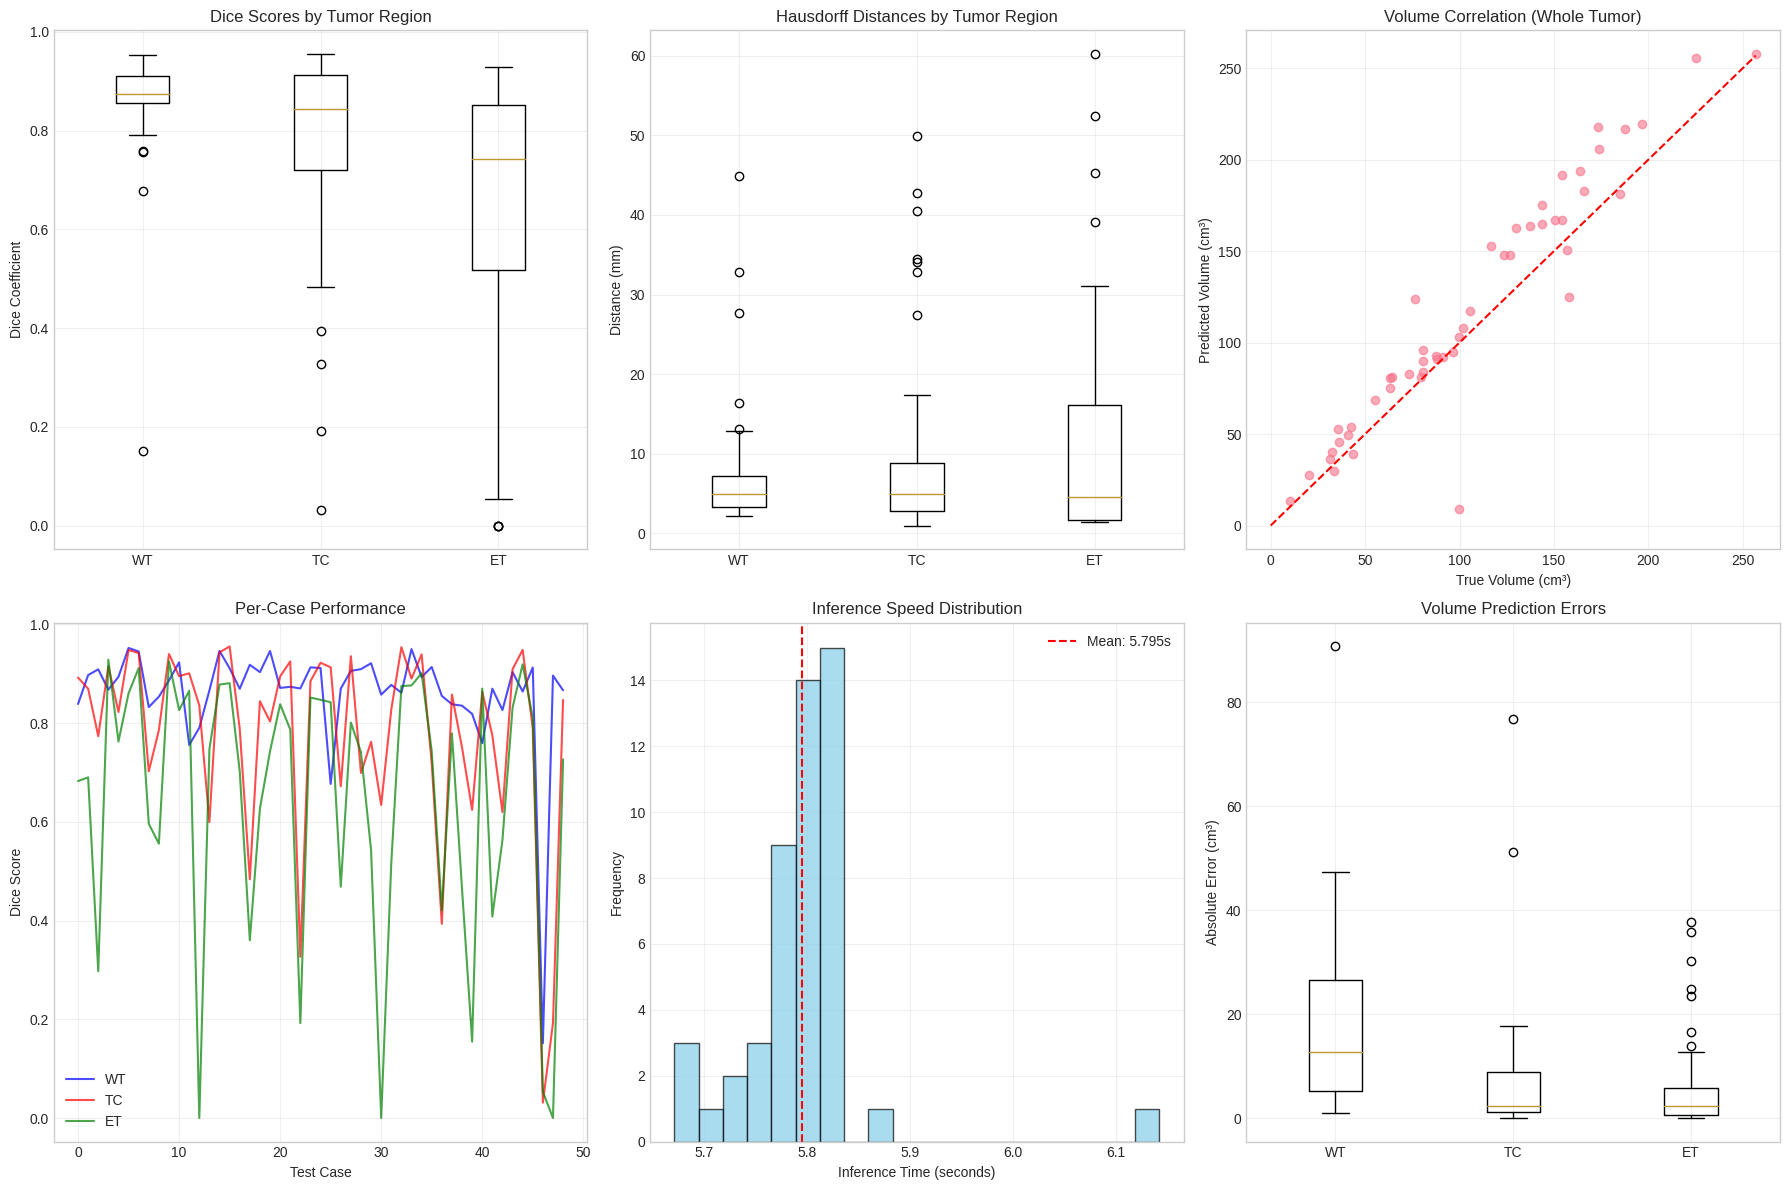

In [8]:
print("PERFORMANCE SUMMARY:")
print("=" * 50)

summary_stats = {}
for region in ['WT', 'TC', 'ET']:
    dice_mean = results_df[f'{region}_dice'].mean()
    dice_std = results_df[f'{region}_dice'].std()

    # Count infinity cases
    inf_cases = (results_df[f'{region}_hausdorff'] == np.inf).sum()

    hausdorff_mean = results_df[f'{region}_hausdorff'].replace([np.inf, -np.inf], np.nan).mean()
    hausdorff_std = results_df[f'{region}_hausdorff'].replace([np.inf, -np.inf], np.nan).std()

    print(f"{region} Region:")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Hausdorff: {hausdorff_mean:.2f} ± {hausdorff_std:.2f} mm (∞ cases: {inf_cases})")

    summary_stats[region] = {
        'dice_mean': dice_mean,
        'dice_std': dice_std,
        'hausdorff_mean': hausdorff_mean,
        'hausdorff_std': hausdorff_std
    }

# Inference speed analysis
mean_inference_time = np.mean(inference_times)
print(f"\nINFERENCE SPEED:")
print(f"  Average: {mean_inference_time:.3f}s per volume")
print(f"  Throughput: {1 / mean_inference_time:.1f} volumes/second")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Dice scores per region
regions = ['WT', 'TC', 'ET']
dice_data = [results_df[f'{region}_dice'] for region in regions]
axes[0, 0].boxplot(dice_data, labels=regions)
axes[0, 0].set_title('Dice Scores by Tumor Region')
axes[0, 0].set_ylabel('Dice Coefficient')
axes[0, 0].grid(True, alpha=0.3)

# Hausdorff distances per region
hausdorff_data = [results_df[f'{region}_hausdorff'] for region in regions]
axes[0, 1].boxplot(hausdorff_data, labels=regions)
axes[0, 1].set_title('Hausdorff Distances by Tumor Region')
axes[0, 1].set_ylabel('Distance (mm)')
axes[0, 1].grid(True, alpha=0.3)

# Volume correlation
axes[0, 2].scatter(results_df['WT_vol_true'], results_df['WT_vol_pred'], alpha=0.6)
axes[0, 2].plot([0, results_df['WT_vol_true'].max()], [0, results_df['WT_vol_true'].max()], 'r--')
axes[0, 2].set_xlabel('True Volume (cm³)')
axes[0, 2].set_ylabel('Predicted Volume (cm³)')
axes[0, 2].set_title('Volume Correlation (Whole Tumor)')
axes[0, 2].grid(True, alpha=0.3)

# Per-case performance
case_indices = range(len(results_df))
axes[1, 0].plot(case_indices, results_df['WT_dice'], 'b-', alpha=0.7, label='WT')
axes[1, 0].plot(case_indices, results_df['TC_dice'], 'r-', alpha=0.7, label='TC')
axes[1, 0].plot(case_indices, results_df['ET_dice'], 'g-', alpha=0.7, label='ET')
axes[1, 0].set_xlabel('Test Case')
axes[1, 0].set_ylabel('Dice Score')
axes[1, 0].set_title('Per-Case Performance')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Inference time distribution
axes[1, 1].hist(inference_times, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(mean_inference_time, color='red', linestyle='--',
                   label=f'Mean: {mean_inference_time:.3f}s')
axes[1, 1].set_xlabel('Inference Time (seconds)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Inference Speed Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Volume error analysis
volume_errors = [results_df[f'{region}_vol_error'] for region in regions]
axes[1, 2].boxplot(volume_errors, labels=regions)
axes[1, 2].set_title('Volume Prediction Errors')
axes[1, 2].set_ylabel('Absolute Error (cm³)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# 🔬 Robustness Analysis Visualization

ROBUSTNESS ANALYSIS:


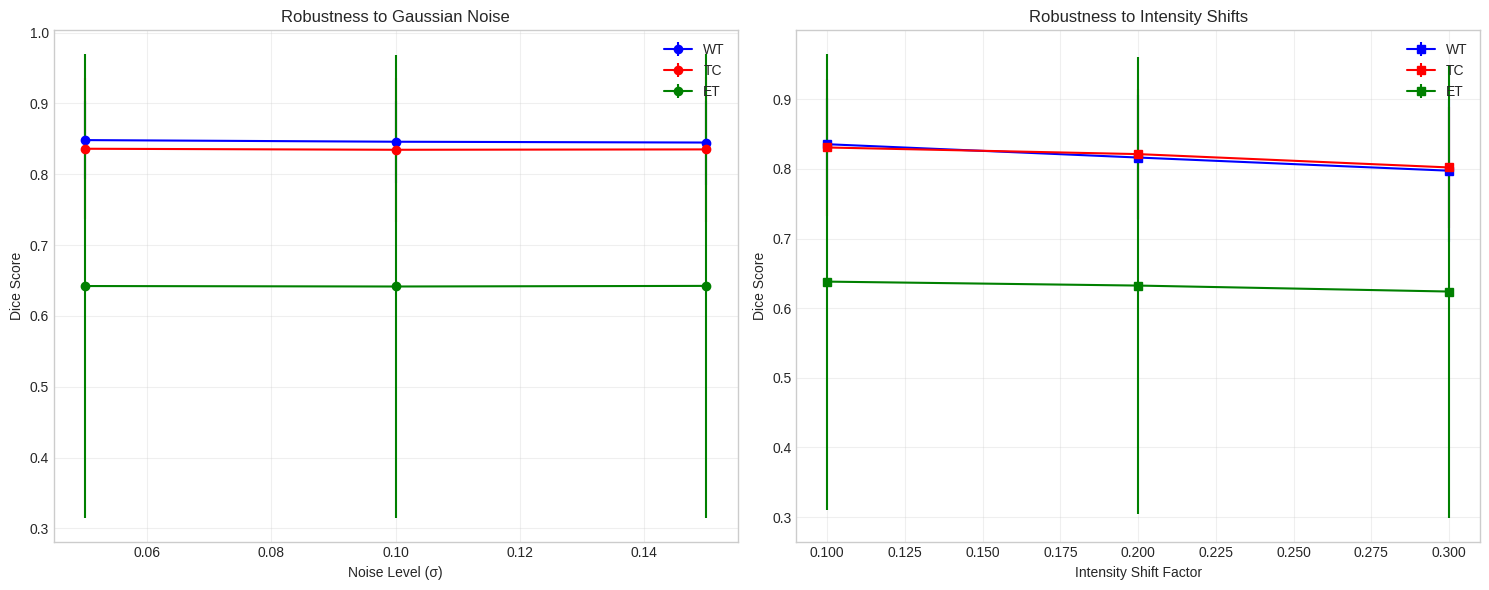

In [9]:
if robustness_summary['noise']:
    print("ROBUSTNESS ANALYSIS:")
    print("=" * 30)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Noise robustness
    noise_levels = sorted(robustness_summary['noise'].keys())
    regions = ['WT', 'TC', 'ET']
    colors = ['blue', 'red', 'green']

    for i, region in enumerate(regions):
        noise_dice_means = []
        noise_dice_stds = []
        for level in noise_levels:
            dice_values = robustness_summary['noise'][level][region]
            noise_dice_means.append(np.mean(dice_values))
            noise_dice_stds.append(np.std(dice_values))

        axes[0].errorbar(noise_levels, noise_dice_means, yerr=noise_dice_stds,
                         marker='o', label=region, color=colors[i])

    axes[0].set_xlabel('Noise Level (σ)')
    axes[0].set_ylabel('Dice Score')
    axes[0].set_title('Robustness to Gaussian Noise')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Intensity shift robustness
    intensity_levels = sorted(robustness_summary['intensity'].keys())

    for i, region in enumerate(regions):
        intensity_dice_means = []
        intensity_dice_stds = []
        for level in intensity_levels:
            dice_values = robustness_summary['intensity'][level][region]
            intensity_dice_means.append(np.mean(dice_values))
            intensity_dice_stds.append(np.std(dice_values))

        axes[1].errorbar(intensity_levels, intensity_dice_means, yerr=intensity_dice_stds,
                         marker='s', label=region, color=colors[i])

    axes[1].set_xlabel('Intensity Shift Factor')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Robustness to Intensity Shifts')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(results_dir / 'robustness_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# 🏥 Clinical Report Generation

In [10]:
def generate_clinical_report(case_results, case_id):
    """Generate a clinical-style report for a case"""

    # Volume assessments
    wt_volume = case_results[f'WT_vol_pred']
    tc_volume = case_results[f'TC_vol_pred']
    et_volume = case_results[f'ET_vol_pred']

    # Performance metrics
    wt_dice = case_results[f'WT_dice']

    # Clinical recommendations based on volume and confidence
    if wt_volume > 20:
        urgency = "Urgent Review"
        recommendation = "Large tumor burden detected. Immediate multidisciplinary consultation recommended."
    elif wt_volume > 5:
        urgency = "Priority Review"
        recommendation = "Moderate tumor burden. Clinical correlation and follow-up recommended."
    else:
        urgency = "Routine Follow-up"
        recommendation = "Small or minimal tumor detected. Routine monitoring appropriate."

    # Confidence assessment based on Dice score
    if wt_dice > 0.85:
        confidence = "High"
    elif wt_dice > 0.7:
        confidence = "Moderate"
    else:
        confidence = "Low"

    report = {
        "patient_id": case_id,
        "analysis_date": "2025-09-04",
        "tumor_volumes": {
            "whole_tumor_cm3": round(wt_volume, 2),
            "tumor_core_cm3": round(tc_volume, 2),
            "enhancing_tumor_cm3": round(et_volume, 2)
        },
        "ai_confidence": confidence,
        "clinical_urgency": urgency,
        "recommendation": recommendation,
        "technical_notes": f"Model achieved {wt_dice:.3f} Dice score for whole tumor segmentation"
    }

    return report

# Generate sample reports
print("CLINICAL REPORT EXAMPLES:")
print("=" * 40)

sample_cases = results_df.head(3)
sample_reports = []

for _, case in sample_cases.iterrows():
    report = generate_clinical_report(case, case['case_id'])
    sample_reports.append(report)

    print(f"\nCase: {report['patient_id']}")
    print(f"Whole Tumor: {report['tumor_volumes']['whole_tumor_cm3']} cm³")
    print(f"Tumor Core: {report['tumor_volumes']['tumor_core_cm3']} cm³")
    print(f"Enhancing: {report['tumor_volumes']['enhancing_tumor_cm3']} cm³")
    print(f"Confidence: {report['ai_confidence']}")
    print(f"Urgency: {report['clinical_urgency']}")
    print(f"Recommendation: {report['recommendation']}")

CLINICAL REPORT EXAMPLES:

Case: BRATS_467
Whole Tumor: 125.06 cm³
Tumor Core: 92.66 cm³
Enhancing: 6.59 cm³
Confidence: Moderate
Urgency: Urgent Review
Recommendation: Large tumor burden detected. Immediate multidisciplinary consultation recommended.

Case: BRATS_209
Whole Tumor: 82.73 cm³
Tumor Core: 35.2 cm³
Enhancing: 24.71 cm³
Confidence: High
Urgency: Urgent Review
Recommendation: Large tumor burden detected. Immediate multidisciplinary consultation recommended.

Case: BRATS_181
Whole Tumor: 255.61 cm³
Tumor Core: 47.64 cm³
Enhancing: 9.96 cm³
Confidence: High
Urgency: Urgent Review
Recommendation: Large tumor burden detected. Immediate multidisciplinary consultation recommended.


# 💾 Save Results and Model Card Data

In [11]:
# Save comprehensive results
results_df.to_csv(results_dir / 'detailed_evaluation_results.csv', index=False)

# Save summary statistics
summary_df = pd.DataFrame(summary_stats).T
summary_df.to_csv(results_dir / 'summary_statistics.csv')

# Save sample reports
with open(results_dir / 'sample_clinical_reports.json', 'w') as f:
    json.dump(sample_reports, f, indent=2)

# Save robustness results
with open(results_dir / 'robustness_analysis.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    rob_summary_serializable = {}
    for test_type in robustness_summary:
        rob_summary_serializable[test_type] = {}
        for level in robustness_summary[test_type]:
            rob_summary_serializable[test_type][level] = {}
            for region in robustness_summary[test_type][level]:
                rob_summary_serializable[test_type][level][region] = [
                    float(x) for x in robustness_summary[test_type][level][region]
                ]
    json.dump(rob_summary_serializable, f, indent=2)

# Generate Model Card data
model_card = {
    "model_name": "nnU-Net 2025 Brain Tumor Segmentation",
    "version": "1.0",
    "architecture": "5-level U-Net with deep supervision",
    "training_data": {
        "dataset": "Medical Segmentation Decathlon - Brain Tumor",
        "total_volumes": 484,
        "train_volumes": int(0.8 * 484),
        "val_volumes": int(0.1 * 484),
        "test_volumes": TEST_VOLUMES
    },
    "performance_metrics": {
        "whole_tumor_dice": f"{summary_stats['WT']['dice_mean']:.4f} ± {summary_stats['WT']['dice_std']:.4f}",
        "tumor_core_dice": f"{summary_stats['TC']['dice_mean']:.4f} ± {summary_stats['TC']['dice_std']:.4f}",
        "enhancing_tumor_dice": f"{summary_stats['ET']['dice_mean']:.4f} ± {summary_stats['ET']['dice_std']:.4f}",
        "average_inference_time": f"{mean_inference_time:.3f} seconds",
        "training_time": f"{training_metrics['training_time_hours']:.1f} hours"
    },
    "clinical_applications": [
        "Brain tumor volume quantification",
        "Surgical planning support",
        "Treatment response monitoring",
        "Radiological workflow enhancement"
    ],
    "limitations": [
        "Trained on specific MRI protocols and may not generalize to all scanners",
        "Performance varies with tumor size and location",
        "Requires expert validation for clinical use",
        "Not FDA approved for diagnostic use"
    ],
    "ethical_considerations": [
        "Designed following medical AI best practices",
        "Requires human oversight for all clinical decisions",
        "Performance disparities across different patient populations should be monitored",
        "Not intended to replace radiologist expertise"
    ]
}

with open(results_dir / 'model_card.json', 'w') as f:
    json.dump(model_card, f, indent=2)

print(f"\nEVALUATION COMPLETE!")
print(f"All results saved to: {results_dir}")
print(f"{len(results_df)} test cases processed")
print(f"{len(sample_reports)} clinical reports generated")
print(f"Robustness testing completed")
print(f"Model card generated")
print(f"\nReady for Streamlit UI integration")


EVALUATION COMPLETE!
All results saved to: /kaggle/working/evaluation_results
49 test cases processed
3 clinical reports generated
Robustness testing completed
Model card generated

Ready for Streamlit UI integration


In [12]:
import shutil

zip_path = "/kaggle/working/evaluation_results_all.zip"
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', results_dir)

print(f"📦 All evaluation outputs saved to: {zip_path}")

📦 All evaluation outputs saved to: /kaggle/working/evaluation_results_all.zip
